# Phase-Amplitude Coupling

This notebook demonstrates how to use YASA to calculate phase-amplitude coupling (PAC) between two frequency bands.

Please make sure to install the latest version of YASA first by typing the following line in your terminal or command prompt:

`pip install --upgrade yasa`

If you are not familiar with PAC methods, I highly recommend reading the two papers below:

* Tort, A. B. L., Komorowski, R., Eichenbaum, H., & Kopell, N. (2010). Measuring phase-amplitude coupling between neuronal oscillations of different frequencies. *Journal of Neurophysiology, 104(2), 1195–1210.* https://doi.org/10.1152/jn.00106.2010

* Aru, J., Aru, J., Priesemann, V., Wibral, M., Lana, L., Pipa, G., Singer, W., & Vicente, R. (2015). Untangling cross-frequency coupling in neuroscience. *Current Opinion in Neurobiology, 31, 51–61.*  https://doi.org/10.1016/j.conb.2014.08.002

In [1]:
import mne
import yasa
import numpy as np
import pandas as pd
import pingouin as pg

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='ticks', font_scale=1.2)

# Load EEG data
f = np.load('data_full_6hrs_100Hz_Cz+Fz+Pz.npz')
data, ch_names = f['data'], f['chan']
sf = 100.
times = np.arange(data.size) / sf

# Keep only Cz
data = data[0, :].astype(np.float64)
print(data.shape, np.round(data[0:5], 3))

(2161058,) [15.797 22.307 39.922 25.657 27.094]


In [2]:
# Load the hypnogram data
hypno = np.loadtxt('data_full_6hrs_100Hz_hypno_30s.txt').astype(int)
print(hypno.shape, 'Unique values =', np.unique(hypno))

# Upsample to data
hypno = yasa.hypno_upsample_to_data(hypno=hypno, sf_hypno=1/30, data=data, sf_data=sf)

30-Sep-20 09:49:45 | WARNING | Hypnogram is SHORTER than data by 10.58 seconds. Padding hypnogram with last value to match data.size.


(720,) Unique values = [0 1 2 3 4]


## Event-locked analyses

One PAC approach that has been used in several recent publications is to first detect slow-waves, and then calculate the PAC based on epochs that are centered around the negative peak of the slow-waves.

For example, this is from the Methods section of [Winer et al., J Neuro 2019](https://doi.org/10.1523/JNEUROSCI.0503-19.2019):

> *For event-locked cross-frequency analyses (Dvorak and Fenton, 2014; Staresina et al.,2015; Helfrich et al., 2018), the normalized SO trough-locked data were first filtered into the SO component (0.1–1.25 Hz), and then the instantaneous phase angle was extracted after applying a Hilbert transform. Then the same trials were filtered between 12 and 16 Hz, and the instantaneous amplitude was extracted from the Hilbert transform. Only the time range from 2 to 2 s was considered, to avoid filter edge artifacts. For every subject, channel, and epoch, the maximal sleep spindle amplitude and corresponding SO phase angle were detected. The mean circular direction and resultant vector length across all NREM events were determined using the CircStat toolbox(Berens, 2009).*

YASA provides some convenient tools to automatize these steps. Specifically, the ``coupling`` argument of the [yasa.sw_detect](https://raphaelvallat.com/yasa/build/html/generated/yasa.sw_detect.html) allows us to replicate these exact same steps:

In [3]:
sw = yasa.sw_detect(data, sf, ch_names=["Cz"], hypno=hypno, include=(2, 3), coupling=True, freq_sp=(12, 16))
events = sw.summary()
events.round(3)

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


,Start,NegPeak,MidCrossing,PosPeak,End,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency,SigmaPeak,PhaseAtSigmaPeak,ndPAC,Stage,Channel,IdxChannel
0,572.23,572.93,573.15,573.35,574.08,1.85,-73.967,65.180,139.147,632.488,0.541,573.46,0.255,0.202,2,Cz,0
1,591.76,591.99,592.20,592.35,592.56,0.80,-112.435,55.743,168.178,800.849,1.250,592.75,-1.174,0.467,2,Cz,0
2,631.90,632.16,632.74,632.96,633.18,1.28,-45.324,43.926,89.251,153.880,0.781,631.77,1.340,0.422,2,Cz,0
3,644.24,644.60,644.78,644.96,645.14,0.90,-60.872,65.218,126.089,700.497,1.111,644.13,1.175,0.083,2,Cz,0
4,645.14,645.31,645.54,645.86,646.07,0.93,-55.222,36.133,91.355,397.195,1.075,644.13,1.175,0.154,2,Cz,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2850,20510.61,20510.79,20510.99,20511.11,20511.24,0.63,-66.765,25.390,92.155,460.774,1.587,20512.79,0.995,0.038,2,Cz,0
2851,20520.10,20520.35,20521.12,20521.91,20522.17,2.07,-44.161,55.213,99.374,129.057,0.483,20520.65,-1.707,0.394,2,Cz,0
2852,20525.90,20526.23,20526.47,20526.71,20527.28,1.38,-163.348,81.533,244.881,1020.336,0.725,20525.08,0.815,0.384,2,Cz,0
2853,20531.47,20531.70,20531.94,20532.58,20532.91,1.44,-50.424,77.228,127.652,531.884,0.694,20532.43,-0.872,0.158,2,Cz,0


As explained in the documentation of the [yasa.sw_detect](https://raphaelvallat.com/yasa/build/html/generated/yasa.sw_detect.html), we get some additional columns in the output dataframe:

1) The ``SigmaPeak`` column contains the timestamp (in seconds from the beginning of the recording) where the sigma-filtered (12 - 16 Hz, see ``freq_sp``) amplitude is at its maximal. This is calculated separately for each detected slow-wave, using a **4-seconds epoch centered around the negative peak of the slow-wave**.

2) The ``PhaseAtSigmaPeak`` column contains the phase (in radians) of the slow-wave filtered signal (0.3 - 2 Hz, see ``freq_sw``) at ``SigmaPeak``. Using the [Pingouin package](https://pingouin-stats.org/), we can then easily extract and visualize the direction and strength of coupling across all channels:

Circular mean: -0.178 rad
Vector length: 0.167


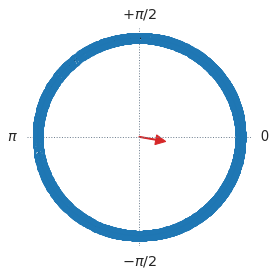

In [4]:
import pingouin as pg
pg.plot_circmean(events['PhaseAtSigmaPeak'])
print('Circular mean: %.3f rad' % pg.circ_mean(events['PhaseAtSigmaPeak']))
print('Vector length: %.3f' % pg.circ_r(events['PhaseAtSigmaPeak']))

3) The ``ndPAC`` columns contains the normalized mean vector length (also called the normalized direct PAC, see [Ozkurt 2012](https://doi.org/10.1109/TBME.2012.2194783)). Note that ``ndPAC`` should be highly correlated the vector length of the ``PhaseAtSigmaPeak``. It may be more accurate though since it is calculated on the entire 4-seconds epoch.

For more details, please refer to:

* Özkurt, T. E. (2012). Statistically Reliable and Fast Direct Estimation of Phase-Amplitude Cross-Frequency Coupling. IEEE Transactions on Biomedical Engineering, 59(7), 1943–1950. https://doi.org/10.1109/TBME.2012.2194783

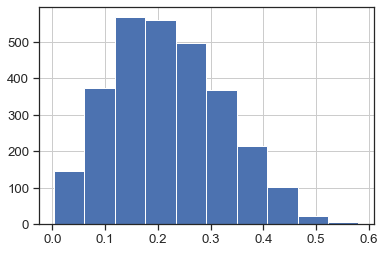

In [5]:
# Distribution of ndPAC value: 
events['ndPAC'].hist();

In [6]:
# This should be close to the vector length that we calculated above
events['ndPAC'].mean()

0.21858686994116763

*************************

## Data-driven PAC

Here, rather than focusing on event-locked coupling (e.g. based on slow-waves detection), we'll simply use epochs of 15-seconds of N2 sleep to estimate PAC across a range of phase and amplitude frequencies.

To calculate formal phase-amplitude coupling, we'll be using the [tensorpac](https://etiennecmb.github.io/tensorpac/) package. Make sure to install it using: 

`pip install -U tensorpac`.

In [7]:
# Segment N2 sleep into 15-seconds non-overlapping epochs
_, data_N2 = yasa.sliding_window(data[hypno == 2], sf, window=15)

# We end up with 636 epochs of 15-seconds
data_N2.shape

(636, 1500)

In [8]:
# First, let's define our array of frequencies for phase and amplitude
f_pha = np.arange(0.125, 4.25, 0.25)  # Frequency for phase
f_amp = np.arange(7.25, 25.5, 0.5)  # Frequency for amplitude

f_pha, f_amp

(array([0.125, 0.375, 0.625, 0.875, 1.125, 1.375, 1.625, 1.875, 2.125,
        2.375, 2.625, 2.875, 3.125, 3.375, 3.625, 3.875, 4.125]),
 array([ 7.25,  7.75,  8.25,  8.75,  9.25,  9.75, 10.25, 10.75, 11.25,
        11.75, 12.25, 12.75, 13.25, 13.75, 14.25, 14.75, 15.25, 15.75,
        16.25, 16.75, 17.25, 17.75, 18.25, 18.75, 19.25, 19.75, 20.25,
        20.75, 21.25, 21.75, 22.25, 22.75, 23.25, 23.75, 24.25, 24.75,
        25.25]))

Let's now calculate the comodulogram. Please refer to the [main API of tensorpac](https://etiennecmb.github.io/tensorpac/generated/tensorpac.Pac.html#tensorpac.Pac) for more details

WARNING | MVL is amplitude dependent which means that if the amplitude increases, MVL also increases. You should select a normalization method for correcting this limitation (e.g idpac=(1, 2, 4))
30-Sep-20 09:49:52 | WARNING | MVL is amplitude dependent which means that if the amplitude increases, MVL also increases. You should select a normalization method for correcting this limitation (e.g idpac=(1, 2, 4))


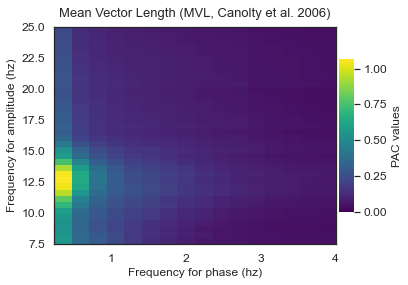

In [9]:
from tensorpac import Pac
sns.set(font_scale=1.1, style='white')

# Define a PAC object
p = Pac(idpac=(1, 0, 0), f_pha=f_pha, f_amp=f_amp, verbose='WARNING')

# Filter the data and extract the PAC values
xpac = p.filterfit(sf, data_N2)

# Plot the comodulogram
p.comodulogram(xpac.mean(-1), title=str(p), vmin=0, plotas='imshow');

In [10]:
# Extract PAC values into a DataFrame
df_pac = pd.DataFrame(xpac.mean(-1), columns=p.xvec, index=p.yvec)
df_pac.columns.name = 'FreqPhase'
df_pac.index.name = 'FreqAmplitude'
df_pac.head(20).round(2)

FreqPhase,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00,3.25,3.50,3.75,4.00
FreqAmplitude,,,,,,,,,,,,,,,,
7.5,0.57,0.37,0.30,0.24,0.18,0.14,0.11,0.09,0.07,0.06,0.06,0.05,0.05,0.05,0.05,0.05
8.0,0.56,0.36,0.29,0.24,0.18,0.15,0.12,0.10,0.08,0.07,0.06,0.05,0.05,0.05,0.05,0.05
8.5,0.54,0.35,0.27,0.22,0.18,0.14,0.12,0.09,0.07,0.06,0.06,0.05,0.05,0.04,0.04,0.04
9.0,0.54,0.35,0.27,0.23,0.19,0.16,0.13,0.10,0.08,0.07,0.06,0.05,0.05,0.05,0.05,0.05
9.5,0.56,0.36,0.29,0.24,0.20,0.18,0.15,0.12,0.10,0.09,0.08,0.06,0.06,0.05,0.05,0.05
10.0,0.60,0.37,0.29,0.24,0.20,0.18,0.15,0.12,0.10,0.09,0.08,0.06,0.06,0.05,0.05,0.05
10.5,0.71,0.42,0.32,0.26,0.23,0.20,0.17,0.15,0.13,0.10,0.09,0.08,0.07,0.06,0.06,0.06
11.0,0.79,0.47,0.34,0.27,0.23,0.21,0.17,0.15,0.13,0.11,0.09,0.08,0.07,0.07,0.06,0.06
11.5,0.95,0.56,0.38,0.31,0.27,0.24,0.20,0.17,0.15,0.13,0.11,0.10,0.09,0.08,0.08,0.07


From the Pandas DataFrame above, we see that the maximal coupling (mean vector length) across all epochs is between the 0.25 Hz frequency for phase and 12.5 hz frequency for amplitude.

As a last example, we now change the ``idpac`` argument to calculate the Modulation Index instead of the Mean Vector Length.

/Users/raphael/.pyenv/versions/3.8.3/lib/python3.8/site-packages/tensorpac/methods/meth_pac.py:59: RuntimeWarning: invalid value encountered in multiply
  p_j = p_j * np.ma.log(p_j).filled(-np.inf)


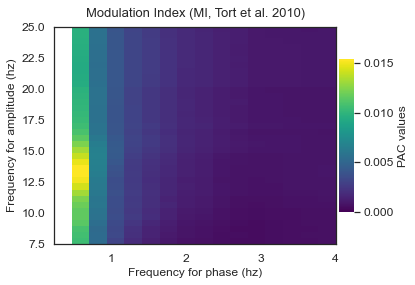

In [11]:
# Define a PAC object
p = Pac(idpac=(2, 0, 0), f_pha=f_pha, f_amp=f_amp, verbose='WARNING')

# Filter the data and extract the PAC values
xpac = p.filterfit(sf, data_N2)

# Plot the comodulogram
p.comodulogram(xpac.mean(-1), title=str(p), plotas='imshow');

In [12]:
df_pac = pd.DataFrame(xpac.mean(-1), columns=p.xvec, index=p.yvec)
df_pac.columns.name = 'FreqPhase'
df_pac.index.name = 'FreqAmplitude'
df_pac.round(3)

FreqPhase,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00,3.25,3.50,3.75,4.00
FreqAmplitude,,,,,,,,,,,,,,,,
7.5,NaN,0.011,0.005,0.003,0.002,0.001,0.001,0.001,0.001,0.001,0.001,0.000,0.001,0.001,0.001,0.001
8.0,NaN,0.011,0.005,0.003,0.002,0.002,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
8.5,NaN,0.011,0.005,0.003,0.002,0.002,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
9.0,NaN,0.011,0.006,0.003,0.002,0.002,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
9.5,NaN,0.012,0.006,0.004,0.003,0.002,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
10.0,NaN,0.012,0.006,0.004,0.003,0.002,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
10.5,NaN,0.012,0.006,0.004,0.003,0.002,0.002,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
11.0,NaN,0.012,0.006,0.004,0.003,0.002,0.002,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
11.5,NaN,0.013,0.006,0.004,0.003,0.002,0.002,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
